### Five qubit MUBs

Using the desarguesian spread and Kantors inequivalent set of MUBs. The setting is a 5 qubit system $\mathcal H = (\mathbb C^2)^{\otimes 5} \cong \mathbb C^{32}$.

In [1]:
import numpy as np
from utils import checkMUBs

In [2]:
p = 2
N = 5

F = GF(p**N, 'x')
x = F.gen()

In [3]:
charpoly(x) # defaults to Conway polynomial

x^5 + x^2 + 1

In [7]:
# GR(4,5)
R = PolynomialRing(Integers(4), 't')
t = R.gen()

In [8]:
factor(t**5 + 3*t**3 + 2*t + 3)

t^5 + 3*t^3 + 2*t + 3

In [9]:
GR = R.quotient(t**5 + 3*t**2 + 2*t + 3, 'w')
w = GR.gen()
GR

Univariate Quotient Polynomial Ring in w over Ring of integers modulo 4 with modulus t^5 + 3*t^2 + 2*t + 3

In [10]:
w**5 + 3*w**2 + 2*w + 3

0

In [11]:
w**(2**5-1) - 1

0

In [12]:
T = [GR(0)] + [w**j for j in range(1, 2**N-1)] + [GR(1)]

def toInt(k):
    return list(F).index(k)

def TeichLift(k):
    return T[toInt(k)]
hat = TeichLift # shortcut

def TSqrt(k):
    for m in T:
        if m**2 == k:
            return m
    raise Exception('Root not found!')

In [13]:
for a in F:
    for b in F:
        if hat(a * b) != hat(a) * hat(b):
            raise Exception('Lift of multiplication is wrong!')

In [14]:
for a in F:
    for b in F:
        h_sum = hat(a + b)
        sum_h = hat(a) + hat(b) + GR(2) * TSqrt(hat(a * b))
        if h_sum != sum_h:
            raise Exception('Lift is wrong!')

In [15]:
def chi(k):
    return np.exp(np.pi * 1j * int(k.trace()))

def Proj(u, v=None):
    if v is None:
        v = u
    return np.outer(u, v.conj().T)

Id = np.eye(2**N)

def Fourier():
    s = np.zeros((2**N, 2**N), dtype='complex128')
    for i, a in enumerate(F):
        for j, b in enumerate(F):
            s[i,j] = chi(a * b) / np.sqrt(2**N)
    return s
FF = Fourier()

def Z(a):
    return np.diag([chi(a * k) for k in F])

def X(b):
    return FF.conj().T @ Z(b) @ FF

# SageMath handles the 2-adic decomposition to define the trace.
def phi(a, b):
    if not isinstance(a, type(w)):
        a = hat(a)
    if not isinstance(b, type(w)):
        b = hat(b)

    return (1j)**(int( (a * b).trace() ))

def D(a, b):
    return phi(a, b) * Z(a) @ X(b)

In [16]:
# Definiion of the rotation operators for the Desarguesian spread.
# The function gives the full basis corresponding to a given parameter \mu.
def V(mu):
    s = np.zeros((2**N, 2**N), dtype='complex128')
    for i, k in enumerate(F):
        s += phi(k, mu * k) * Proj(FF[:, i])
    return s

# We can obtain the whole set of MUBs, ordered
# by the field elements in the following way:
mubsStd = [FF] + [V(mu) for mu in F]

In [17]:
checkMUBs(mubsStd)

MUBs are good!


In [18]:
def FieldTrace(k):
    return sum([k**(2**j) for j in range(N)])

def HatFieldTrace(k):
    return sum([hat(k**(2**j)) for j in range(N)])

In [19]:
for k in F:
    if k.trace() != FieldTrace(k):
        raise Exception('Trace ill-defined.', k)

In [20]:
# Kantor's MUBs
def VK(mu):
    s = np.zeros((2**N, 2**N), dtype='complex128')
    # f = lambda k: mu**2 * k + mu * k.trace() + (mu * k).trace()
    f_hat = lambda k: hat(mu**2 * k) + hat(mu) * HatFieldTrace(k) + HatFieldTrace(mu * k)
    for i, k in enumerate(F):
        s += phi(k, f_hat(k)) * Proj(FF[:, i])
    return s

In [21]:
mubsK = [FF] + [VK(mu) for mu in F]

In [22]:
checkMUBs(mubsK)

MUBs are good!


Defining the Wigner functions.

In [23]:
# Wootters kernel for Desarguesian spread
def Wootters(a, b):
    op = Proj(mubsStd[0][:, toInt(a)]) # Fourier basis
    for xi in F:
        # for nu in F:
        #     d = float(b == xi * a + nu)
        #     op += d * Proj(mubsStd[toInt(xi)+1][:,toInt(nu)])
        nu = b - xi * a
        op += Proj(mubsStd[toInt(xi)+1][:,toInt(nu)])
    return op - Id

# Definition of the Wigner function
def Wigner(state, a, b, kernel):
    return (state @ kernel(a, b)).trace()

def WignerMatrix(state, kernel):
    W = np.zeros((2**N, 2**N))
    for i, a in enumerate(F):
        for j, b in enumerate(F):
            W[i, j] = np.real(Wigner(state, a, b, kernel)) / (2**N)
    return W

# shortcut
def WW(state, approx=True, kernel=Wootters):
    w = WignerMatrix(Proj(state), kernel)
    if approx:
        return np.round(w, 3)
    return w

# Sum the Wigner function along a given curve
def Prob(w, curve):
    s = 0
    for i, a in enumerate(F):
        for j, b in enumerate(F):
            s += w[i,j] * float(b == curve(a))
    return s

In [24]:
# Wootters kernel for Kantor's spread
def Kantor(a, b):
    op = Proj(mubsK[0][:, toInt(a)]) # Fourier basis
    for xi in F:
        nu = b - (xi**2 * a + xi * a.trace() + (xi * a).trace())
        op += Proj(mubsK[toInt(xi)+1][:,toInt(nu)])
    return op - Id

Testing the Wigner function.

In [ ]:
# Kernel and Wigner function testing

from utils import checkPhasePointOperators

class TestSuite:

    def __init__(self):
        pass

    def run(self):
        self.RotationOperators()
        self.RotationCoefficients()
        self.KernelProperties()
        self.TomographicProperties()
        self.Covariance()

        print('All tests have passed successfully!')

    def RotationOperators(self):
        try:
            for mu in F:
                for alpha in F:
                    v_op = V(mu)
                    z_op = Z(alpha)
                    rot_op = v_op @ z_op @ v_op.conj().T
                    disp = D(alpha, mu * alpha)
                    if not np.all(np.isclose(rot_op, disp)):
                        raise Exception('Rotation failed!') 
        finally:
            print('Rotation operators work!')

    def RotationCoefficients(self):
        try:
            for mu in F:
                for k in F:
                    for a in F:
                        c_k = phi(k, k * mu)
                        c_a = phi(a, a * mu)
                        c_ak = phi(k + a, (k + a) * mu)
                        char = chi(mu * a * k)
                        if not np.isclose(c_k * c_a, c_ak * char):
                            raise Exception(
                                'Recurrence relation does not hold!',
                            mu, k, a)
        finally:
            print('Recurrence relation holds for chosen phase!')

    def KernelProperties(self):
        ops = []
        for a in F:
            for b in F:
                ops.append(Wootters(a, b))
        
        checkPhasePointOperators(ops)
        
        if np.all(np.isclose(sum(ops) / 2**N, Id)):
            print('Kernel is normalized!')

    def TomographicProperties(self):
        try:
            # Vertical and horizontal lines
            for nu in F:
                op = np.zeros((2**N, 2**N), dtype='complex128')
                for a in F:
                    op += Wootters(a, nu)
                if not np.all(np.isclose(op / 2**N, Proj(Id[:, toInt(nu)]))):
                    raise Exception('Error with Z eigenbasis!')
                
                op = np.zeros((2**N, 2**N), dtype='complex128')
                for b in F:
                    op += Wootters(nu, b)
                if not np.all(np.isclose(op / 2**N, Proj(FF[:, toInt(nu)]))):
                    raise Exception('Error with X eigenbasis!')
                
            # Arbitrary curve
            for mu in F:
                for nu in F:
                    op = np.zeros((2**N, 2**N), dtype='complex128')
                    for a in F:
                        for b in F:
                            op += Wootters(a, b) * float(b == mu * a + nu)
                    v = mubsStd[toInt(mu)+1][:,toInt(nu)]
                    if not np.all(np.isclose(op / 2**N, Proj(v))):
                        raise Exception('Error with Z_a X_f(a) eigenbasis!')
        finally:
            print('Tomographic properties hold!')
    
    def Covariance(self, verbose=False):
        try:
            count = 0
            for k in F:
                for l in F:
                    for a in F:
                        for b in F:
                            disp = D(k, l)
                            disp_op = disp @ Wootters(a, b) @ disp.conj().T
                            if not np.all(np.isclose(disp_op, Wootters(a+k, b+l))):
                                raise Exception('Not covariant', a, b, k, l)
                            if verbose:
                                if count % 10000 == 0:
                                    print('Checked {} possibilities.'.format(count))
                            count += 1
        finally:
            print('Kernel is covariant!')

    # Testing tomographic probabilities

    def TestProb(self, state):
        w = WW(state, approx=False)
        for mu in F:
            for nu in F:
                wigner_prob = Prob(w, lambda t: mu * t + nu)
                trans_prob  = abs(
                    state.conj() @ mubsStd[toInt(mu)+1][:,toInt(nu)]
                )**2
                if not np.isclose(wigner_prob, trans_prob):
                    raise Exception(
                        'Probabilities do not match!',
                        mu, nu, wigner_prob, trans_prob
                    )
        print('Probabilities are correct!')

In [ ]:
test = TestSuite()
test.run()

In [25]:
import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [26]:
def PlotWigner(w):
    data_array = w.T

    fig = plt.figure(figsize=(8,8), dpi=400)
    
    ax = fig.subplots(subplot_kw = {'projection' : '3d'})
    ax.set_box_aspect(aspect=(4,4,3), zoom=0.85)
    ax.view_init(elev=30, azim=-45, roll=0)

    x_data, y_data = np.meshgrid(
        np.arange(data_array.shape[1]),
        np.arange(data_array.shape[0])
    )

    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_data = data_array.flatten()

    if z_data.min() == 0:
        ax.set_zlim(min(0, z_data.min()), z_data.max() + 1/64)
    else:
        ax.set_zlim(min(0, z_data.min()) - 1/64, z_data.max() + 1/64)

    offset = z_data + np.abs(z_data.min())
    fracs  = offset.astype(float) / offset.max()
    norm   = colors.Normalize(fracs.min(), fracs.max())
    color_vals = cm.viridis(norm(fracs.tolist()))

    ax.bar3d(
        x_data,
        y_data,
        np.zeros(len(z_data)),
        0.95, 0.95, z_data,
        color = color_vals
    )

    # labels = [r'$0$',r'$\sigma$',r'$\sigma^2$',r'$\sigma^3$',
              # r'$\sigma^4$',r'$\sigma^5$',r'$\sigma^6$',r'$\sigma^7$']
    
    # plt.xticks(np.arange(32), labels)
    # plt.yticks(np.arange(1, 33, 1), labels)

    plt.xlabel(r'$\alpha$', fontsize=20)
    plt.ylabel(r'$\beta$', fontsize=20)
    
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.set_zlabel(r'$W(\alpha,\beta)$', fontsize=20)

    ax.xaxis.labelpad=15
    ax.yaxis.labelpad=15
    ax.zaxis.labelpad=20

    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='y', which='major', labelsize=15)

    fig.tight_layout()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)

    return (fig, ax)

In [ ]:
w_std = WW(mubsK[12][:,12], kernel=Wootters)

In [ ]:
w_kan = WW(mubsK[12][:,12], kernel=Kantor)

In [ ]:
fig, ax = PlotWigner(w_std)

In [ ]:
bbox = fig.bbox_inches.from_bounds(1, 0.5, 7, 6)
fig.savefig('./pres_graphs/32_woo_2.eps', format='eps', bbox_inches=bbox)

In [ ]:
fig, ax = PlotWigner(w_kan)

In [ ]:
bbox = fig.bbox_inches.from_bounds(1, 0.5, 7, 6)
fig.savefig('./pres_graphs/32_kan_2.eps', format='eps', bbox_inches=bbox)

Entangled state:

In [28]:
psi3 = WW((Id[:,toInt(x+x^3+x^4)] + Id[:,toInt(x+1)])/np.sqrt(2), kernel=Wootters)

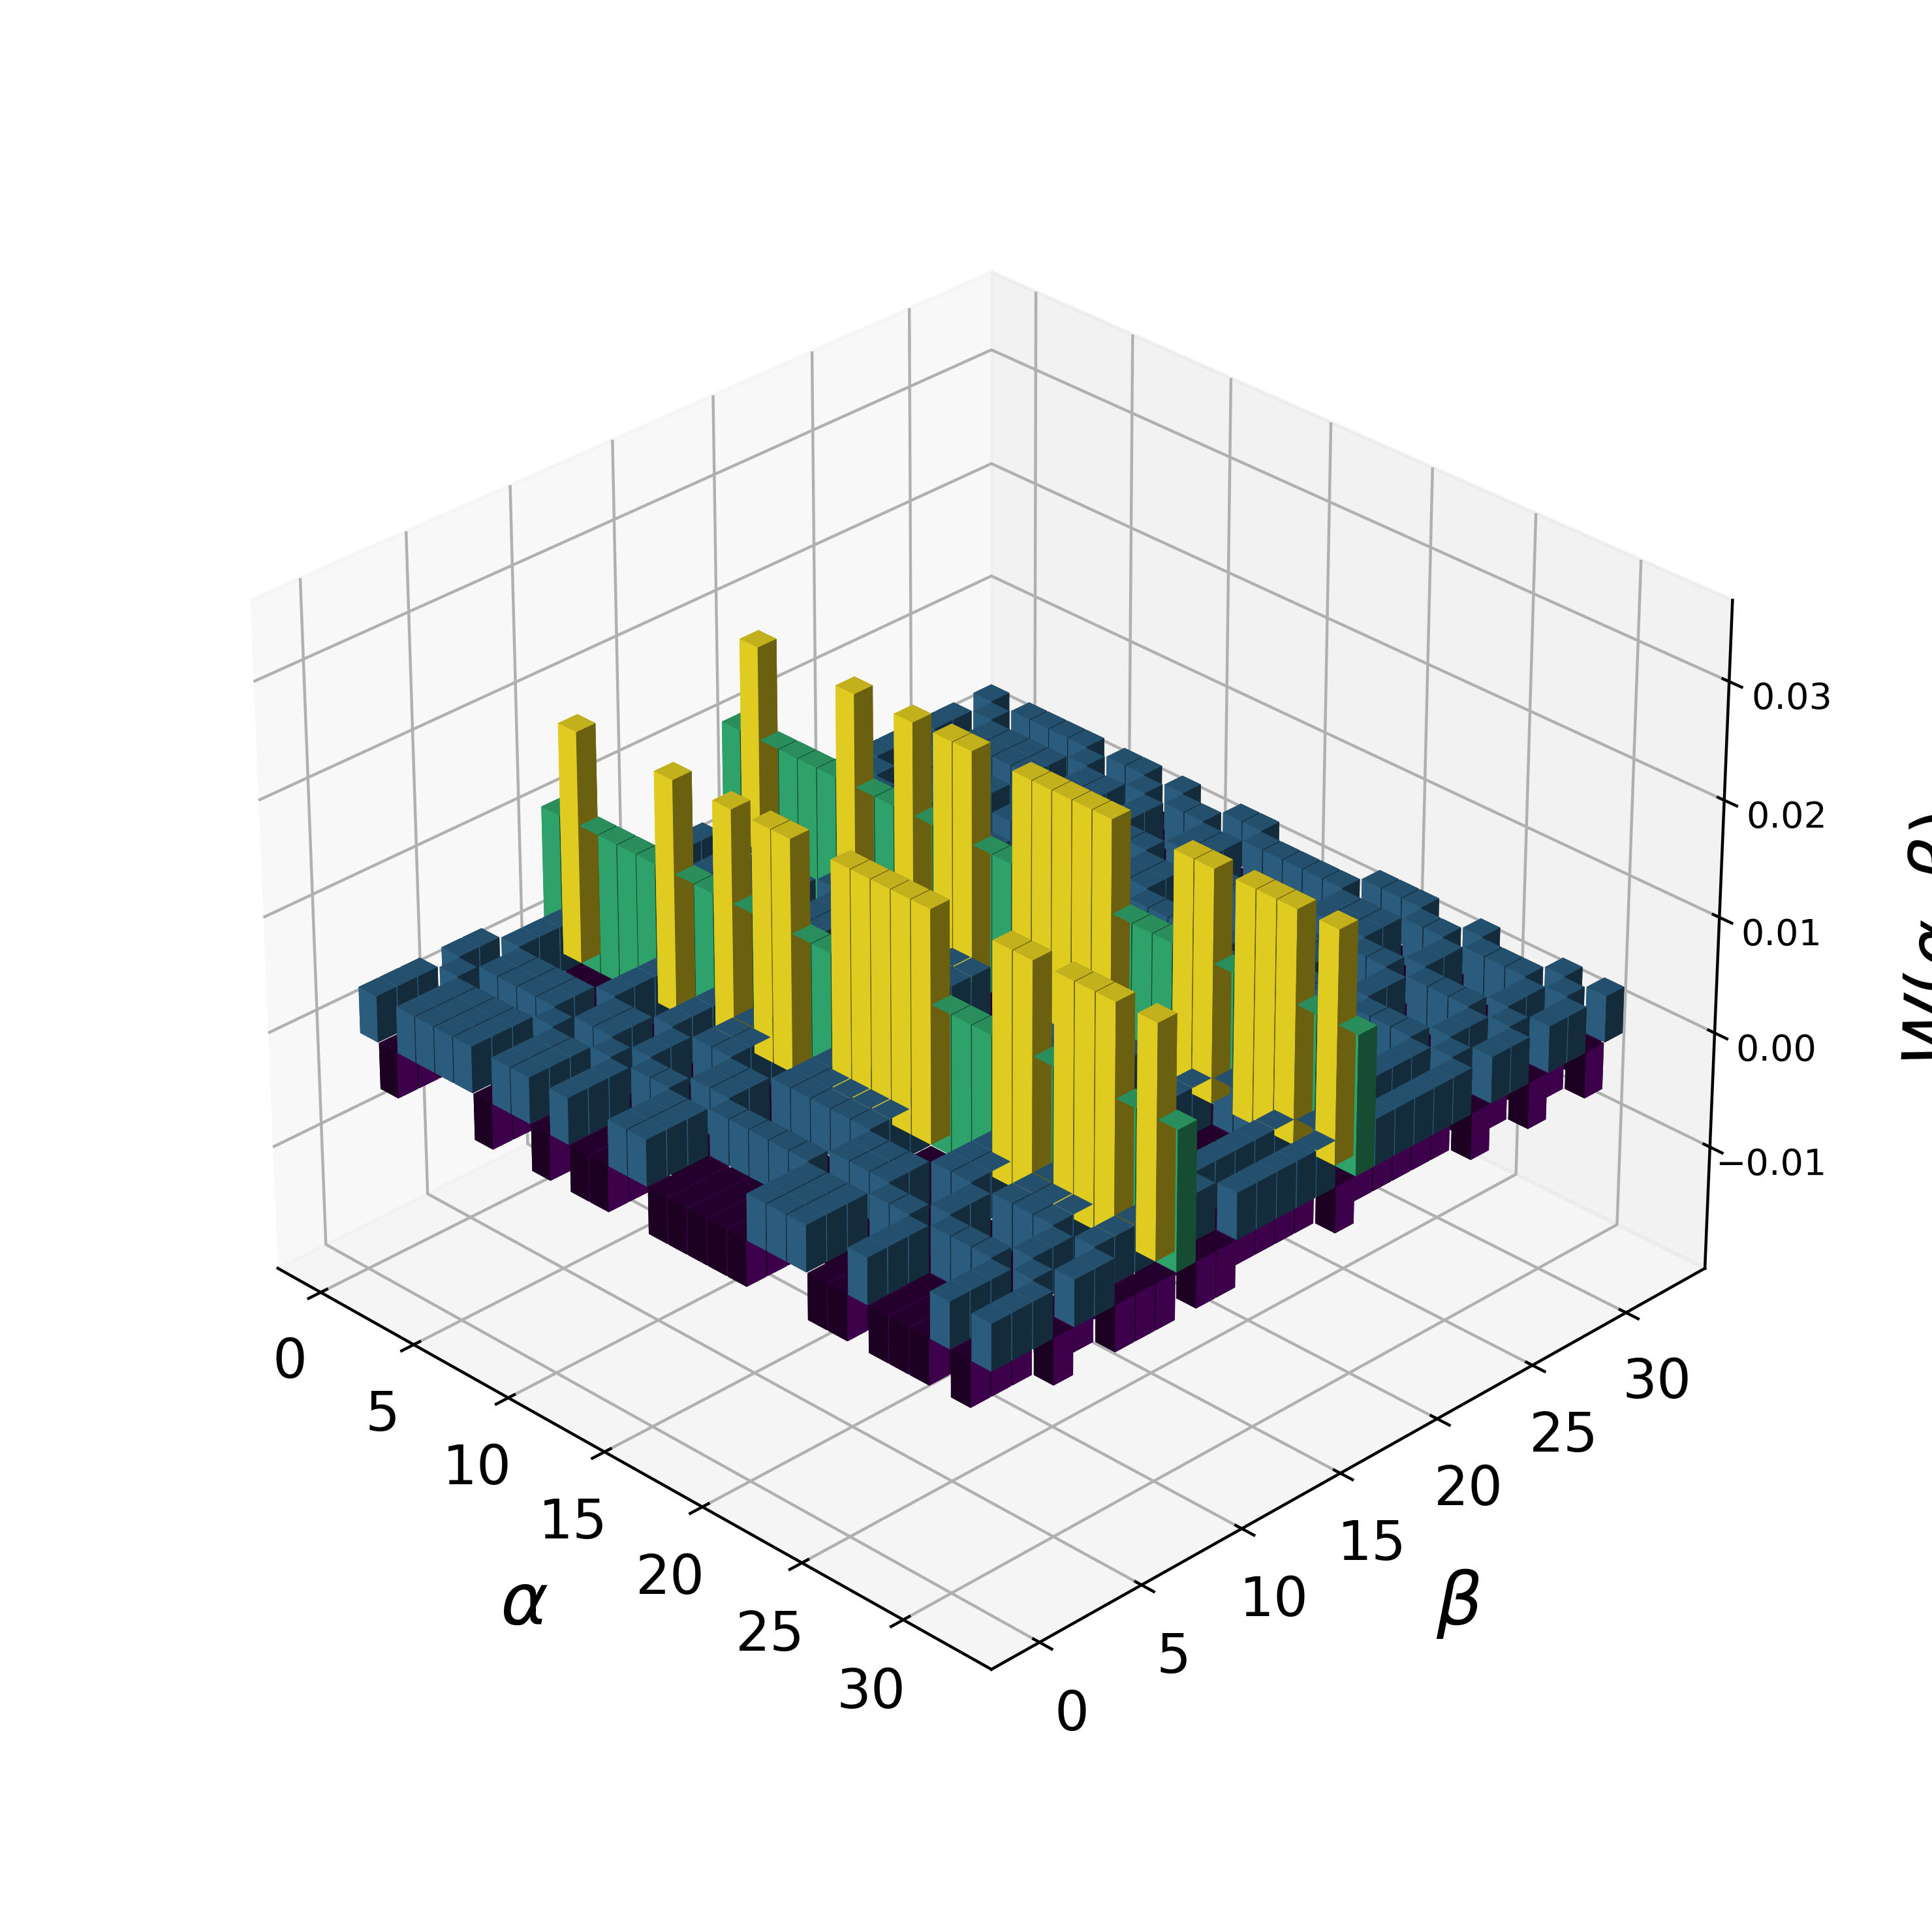

In [29]:
fig, ax = PlotWigner(psi3)

In [31]:
bbox = fig.bbox_inches.from_bounds(1, 0.5, 7, 6)
fig.savefig('./pres_graphs/32_woo_3.eps', format='eps', bbox_inches=bbox)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [32]:
psi3 = WW((Id[:,toInt(x+x^3+x^4)] + Id[:,toInt(x+1)])/np.sqrt(2), kernel=Kantor)

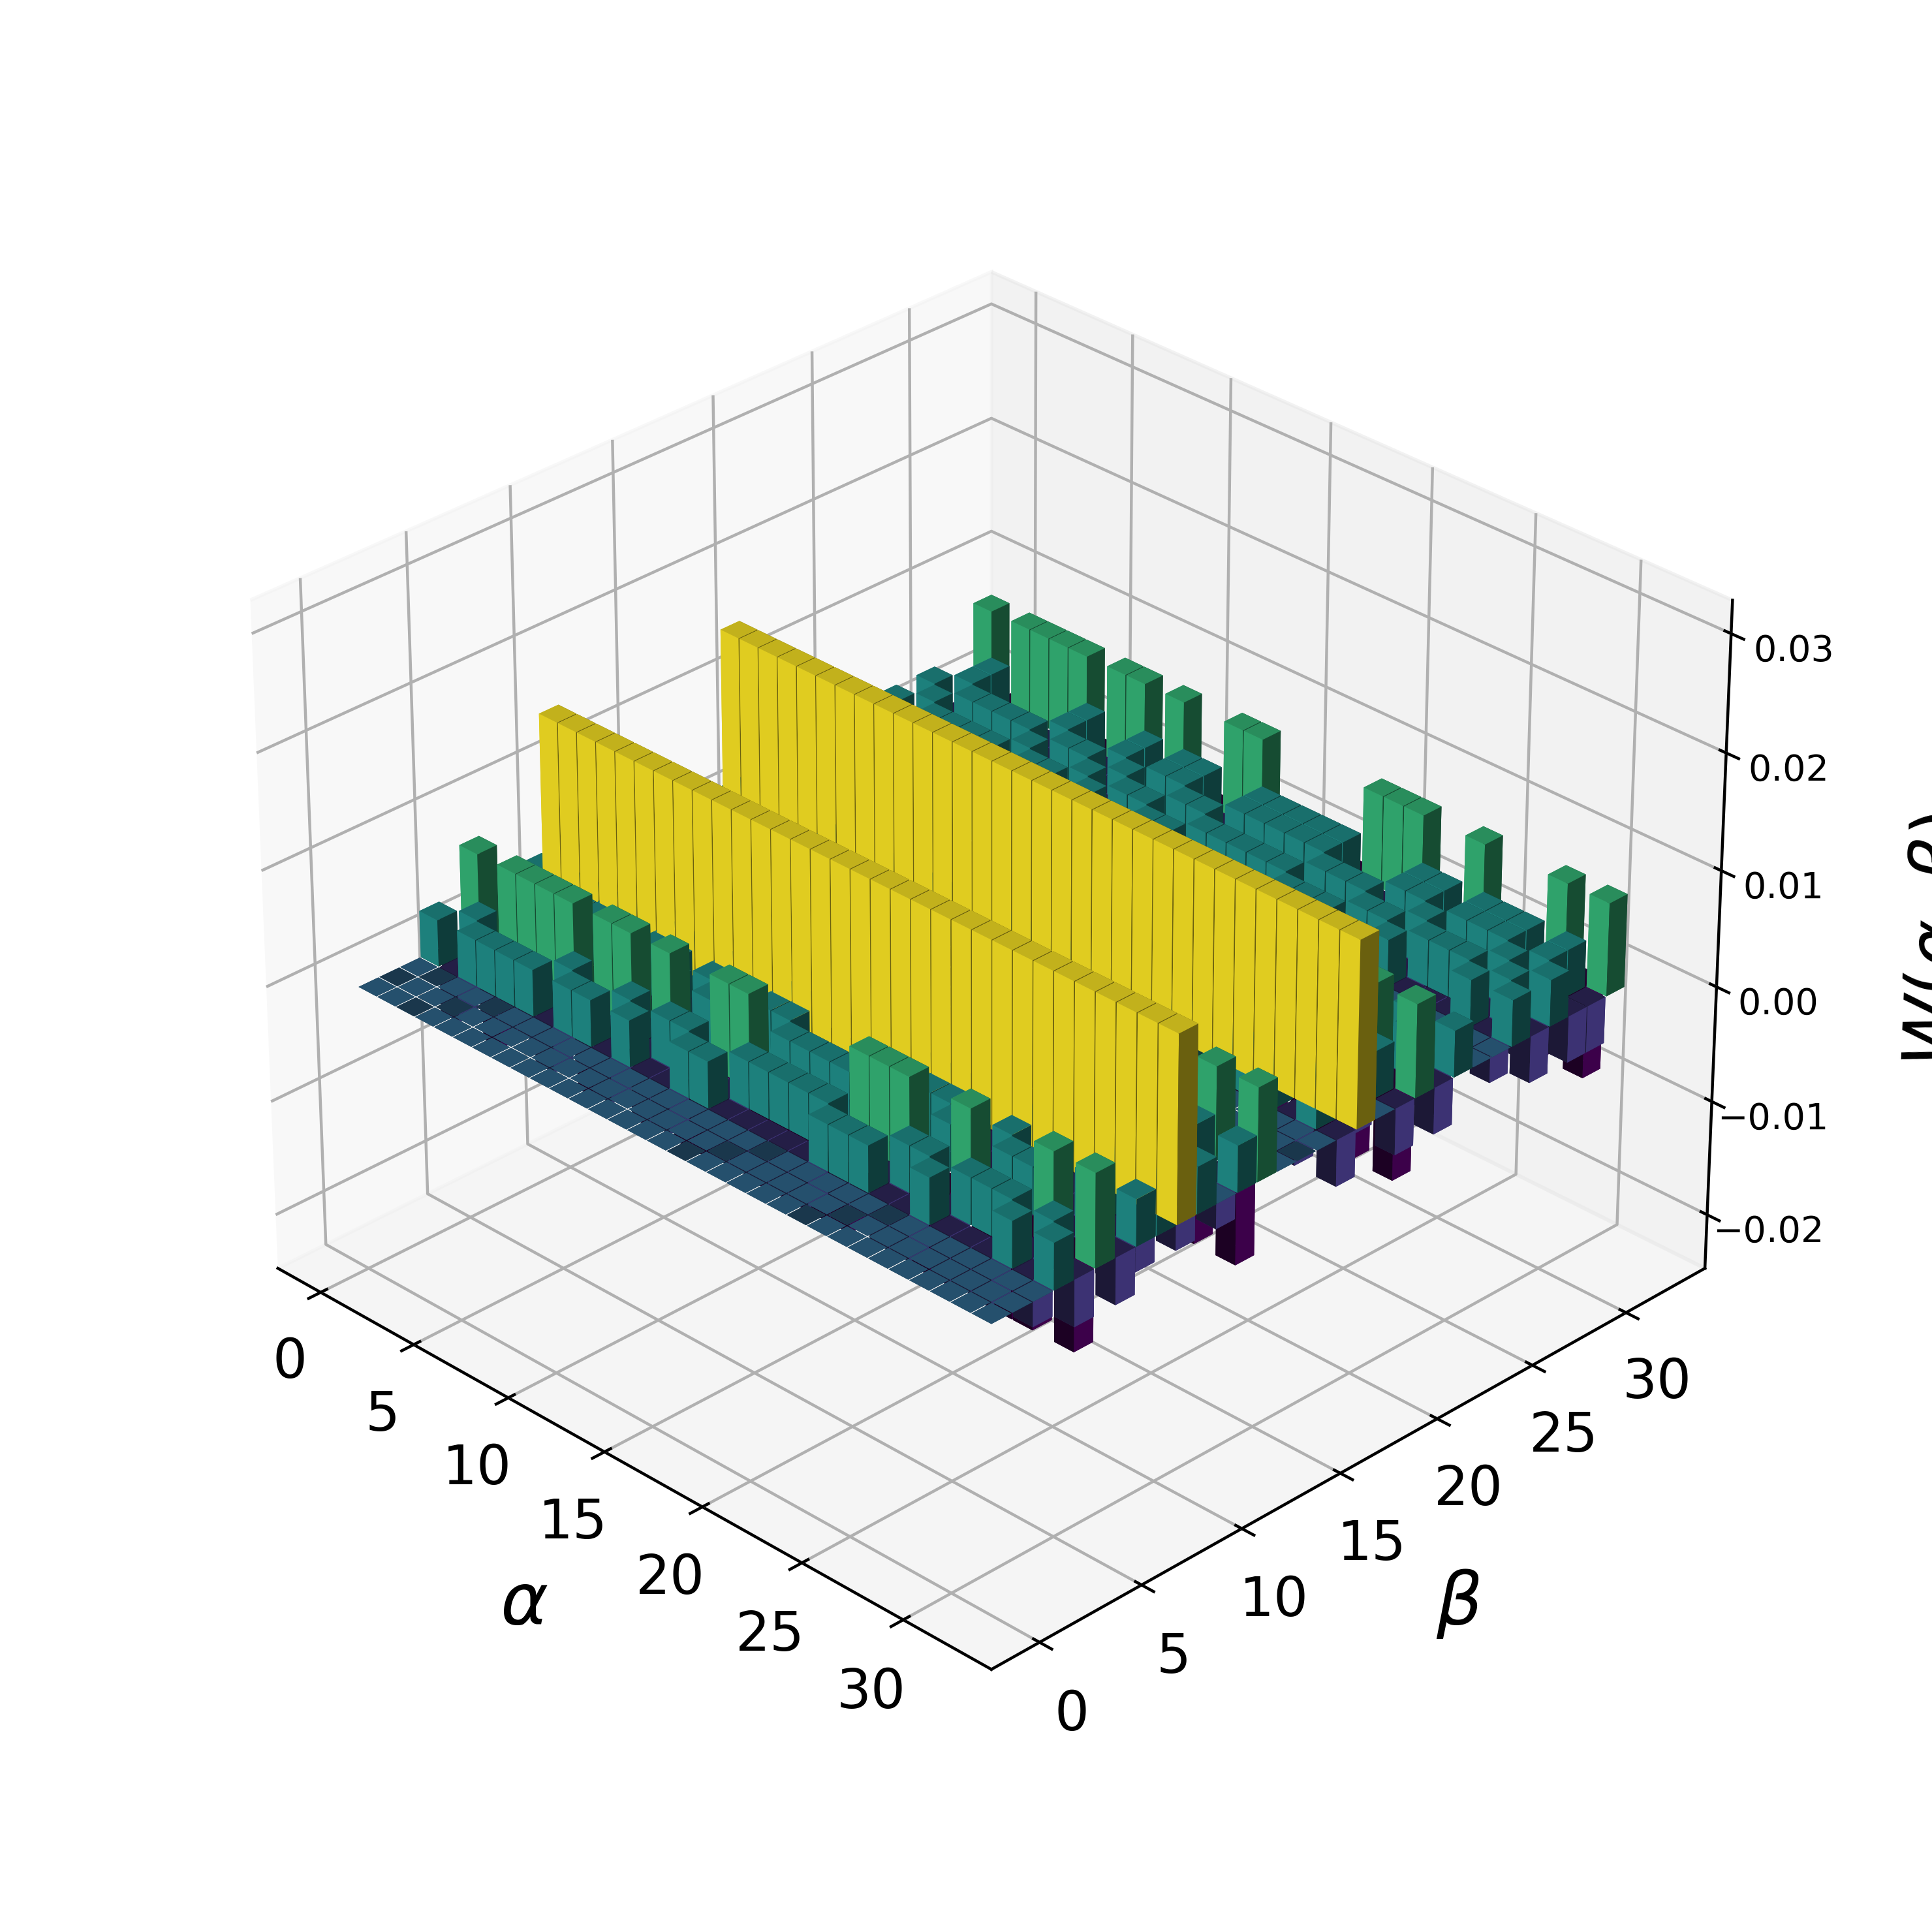

In [33]:
fig, ax = PlotWigner(psi3)

In [34]:
bbox = fig.bbox_inches.from_bounds(1, 0.5, 7, 6)
fig.savefig('./pres_graphs/32_kan_3.eps', format='eps', bbox_inches=bbox)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Analysis of what goes wrong...

In [ ]:
def f(mu):
    return lambda k: mu**2 * k + mu * k.trace() + (mu * k).trace()

def f_hat(mu):
    return lambda k: hat(mu**2 * k) + hat(mu) * HatFieldTrace(k) + HatFieldTrace(mu * k)

In [ ]:
# Verification of the equation (40).
count = 0
for alpha in F:
    for beta in F:
        for s in list(F)[:1]:        
            for k in list(F)[:1]:
                for mu in F:
                    nu = beta - mu * alpha
    
                    psi_mu_nu = mubsStd[toInt(mu)+1][:,toInt(nu)]
                    psi_f_k = mubsK[toInt(s)+1][:,toInt(k)]
    
                    inp = np.abs(psi_mu_nu.conj() @ psi_f_k)**2
    
                    ss = 0
                    for xi in F:
                        c_xif = phi(xi, f_hat(s)(xi))
                        c_ximu = phi(xi, xi * mu)
                        char = chi(xi * (-k + nu))
                        d = int(mu * xi == f(s)(xi))
                        ss += c_xif * conjugate(c_ximu) * char * d / (2**N)


                    if count % 1000 == 0:
                        print('Tested {} possibilities.'.format(count))
                    count += 1
                        
                    if not np.isclose(inp, ss):
                        raise Exception('No equality!', mu, nu, s, k)
print('Equation (40) is valid for all (a,b) and all curves!')

Now for the bad part...

In [ ]:
# Equation (42)

alpha = x
beta  = x
for s in F:
    for k in F:
        inps = 0
        s40 = 0
        for mu in F:
            nu = beta - mu * alpha

            # Inner product sum
            psi_mu_nu = mubsStd[toInt(mu)+1][:,toInt(nu)]
            psi_f_k = mubsK[toInt(s)+1][:,toInt(k)]

            inps += np.abs(psi_mu_nu.conj() @ psi_f_k)**2

            # Right hand side of (40)
            for xi in F:
                c_xif = phi(hat(xi), f_hat(s)(xi))
                c_ximu = phi(xi, mu * xi)
                char = chi(xi * (-k + beta - mu * alpha))
                d = int(mu * xi == f(s)(xi))
                s40 += c_xif * conjugate(c_ximu) * char * d / (2**N)

        # Right hand side of (42)
        s42 = 1
        for xi in list(F)[1:]:
            s42 += chi(xi * (k + beta + f(s)(alpha))) / (2**N)
        
        if not np.isclose(inps, s42):
            print(np.round(inps, 4), np.round(s40, 4), np.round(s42, 4), s, k)
            raise Exception('Sums do not match!')

So it seems to all stem from the fact that $\widehat{f_\mu(x)} \neq f_{\hat\mu}(\hat x)$ for all $x \in F$. Is this true for all presemifield operations? Recall the definition of Kantor's presemifield operation:
$$
\begin{align*}
\mu \circ x = f_\mu(x)
&= \mu^2 x + \mu \, Tr(x) + Tr(\mu x) \\
&= \mu^2 x + \mu \, \sum_{i=0}^{N-1} x^{2^i} + \sum_{j=0}^{N-1} (\mu x)^{2^j}
\end{align*}
$$
According to Kanat we can extend the multiplication of a presemifield $(F,+,\circ)$ to the Teichmüller in the following manner, for the multiplication given by:
$$
x \circ y = \sum a_{ij} x^{2^i} y^{2^j},
$$
the multiplication in $\mathcal T$ is given by:
$$
\hat x \circ \hat y = \sum \hat a_{ij} \hat x^{2^i} \hat y^{2^j}.
$$
We can clearly see that $\hat x \circ \hat y \neq \widehat{x \circ y}$.

In [ ]:
# def f(mu):
#     return lambda k: mu**2 * k + mu * k.trace() + (mu * k).trace()

# def f_hat(mu):
#     return lambda k: hat(mu**2 * k) + hat(mu) * HatFieldTrace(k) + HatFieldTrace(mu * k)
for mu in F:
    for k in F:
        if hat(f(mu)(k)) != f_hat(mu)(k):
            raise Exception('f_hat is not equal to hat_f!', mu, k)

In [ ]:
hat(f(x)(x^2))

In [ ]:
f_hat(x)(x^2)

An example where $\widehat{\mu \circ \kappa} \neq \hat \mu \circ \hat \kappa$ is given by $\mu = x$ and $\kappa = x^2$. In this case $x \circ x^2 = x^4 + 1$ which lifted to $\mathcal T$ is equal to $w^4 + 2w^2 + 1$, while $\hat x \circ \widehat{x^2} = w^4 + 3$. So even when $\mu \xi = f_\mu(\xi)$ in equation (40), it is not so that the phases will be the same. And so the proof seems to be invalid even for presemifield operations. 

A question that is bothering me is _why_ is the lifted multiplication is the form mentioned by Kannat? Empirically it can be seen that simply lifting the evaluation does not generate MUBs, so it is a special reason.